In [1]:
#setup based on this: https://t-redactyl.io/blog/2020/08/reading-s3-data-into-a-spark-dataframe-using-sagemaker.html
import boto3
import json 
import time
import pandas as pd
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, isnan, when, count, col
import matplotlib.pyplot as plt
import sagemaker_pyspark
import botocore.session

## Set Spark Session Configuration

In [3]:
session = botocore.session.get_session()
credentials = session.get_credentials()

In [4]:
client = boto3.client('secretsmanager')
response = client.get_secret_value(
    SecretId='sapient-s3-access'
)
response = json.loads(response['SecretString'])
access_key = response["aws_access_key_id"]
secret_key = response["aws_secret_access_key"]

In [5]:
conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))

In [6]:
spark = (
    SparkSession
    .builder
    .config(conf=conf) \
    .config('fs.s3a.access.key', access_key)
    .config('fs.s3a.secret.key', secret_key)
    .config('spark.network.timeout', 300)
    .config('spark.memory.offHeap.size','4g')
    .config('spark.executor.memory', '16g')
    .appName("sapient")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/17 03:06:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Functions to Load and Read Data

In [7]:
# read from raw bucket + write to refined bucket + aggregate final to the trusted bucket
s3_url_raw = "s3a://sapient-bucket-raw/"
s3_url_refined = "s3a://sapient-bucket-refined/"
s3_url_trusted = "s3a://sapient-bucket-trusted/"
bro_cols_conn = ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 
                 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents']
bro_cols_rep = ['ts', 'level', 'message', 'location']

In [8]:
# ecarbro.json, AIA-1-25.ecar.json, conn.09_00_00-10_00_00.log
def s3_file(file):
    dev_file = f"{s3_url_raw}/{env}/{file}"
    prod_file = ""
    if env == "prod":
      filename = prod_file
    else:
      filename = dev_file
    return filename

In [9]:
def loadAndCheckpoint(type):
    """
    type: ecar, ecar-bro, bro, labels
    This function reads a file from json or log text and writes it as a parquet.
    """
    start_time = time.time()
    if type == 'ecar':
        df = spark.read.json(f"{s3_url_raw}/{env}/{type}/**/**/**/*.json")
        df = df.limit(1000)
        df = df.select(*df.columns, "properties.*").drop('properties')
        df.write.option("maxRecordsPerFile", 100000).mode("overwrite").parquet(f"{s3_url_refined}/{env}/{type}")
    elif type == 'ecar-bro':
        df = spark.read.json(f"{s3_url_raw}/{env}/{type}/**/**/**/*.json")
        # this will extract and flatten nested properties column
        df = df.limit(1000)
        df = df.select(*df.columns, "properties.*").drop('properties')
        df.write.option("maxRecordsPerFile", 100000).mode("overwrite").parquet(f"{s3_url_refined}/{env}/{type}")
    elif type == 'bro':
        df = spark.read.csv(f"{s3_url_raw}/{env}/**/**/*.log", sep="\t", comment="#", header=False)
        df = df.limit(1000)
        df = df.toDF(*bro_cols_conn)
        df.write.option("maxRecordsPerFile", 100000).mode("overwrite").parquet(f"{s3_url_refined}/{env}/{type}")
    elif type == 'labels':
        df = spark.read.csv(f"{s3_url_raw}/{env}/{type}/*.csv", sep=",", header=True)
        df.write.option("maxRecordsPerFile", 100000).mode("overwrite").parquet(f"{s3_url_refined}/{env}/{type}")
    print("--- %s seconds ---" % (time.time() - start_time))
    df.unpersist()

In [10]:
def readCheckpoint(file_type):
    """
    type: ecar, ecar-bro, bro
    """
    s3_parquet_loc = f"{s3_url_refined}/{env}/{file_type}"
    start_time = time.time()
    df = spark.read.parquet(s3_parquet_loc)
    # rdd = spark.sparkContext.parallelize(df.take(1000))
    # print(f"Your dataframe has {rdd.count():,} rows.")
    print("--- %s seconds ---" % (time.time() - start_time))
    return df

## Environment configuration

In [11]:
# env can be dev or prod
env = "dev"

## Data Processing

In [12]:
loadAndCheckpoint('bro')

23/02/17 03:10:58 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


--- 14.024483680725098 seconds ---


In [13]:
df_bro = readCheckpoint('bro')

--- 0.32593274116516113 seconds ---


In [14]:
df_bro.printSchema()

root
 |-- ts: string (nullable = true)
 |-- uid: string (nullable = true)
 |-- id.orig_h: string (nullable = true)
 |-- id.orig_p: string (nullable = true)
 |-- id.resp_: string (nullable = true)
 |-- id.resp_p: string (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- orig_bytes: string (nullable = true)
 |-- resp_bytes: string (nullable = true)
 |-- conn_state: string (nullable = true)
 |-- local_orig: string (nullable = true)
 |-- local_resp: string (nullable = true)
 |-- missed_bytes: string (nullable = true)
 |-- history: string (nullable = true)
 |-- orig_pkts: string (nullable = true)
 |-- orig_ip_bytes: string (nullable = true)
 |-- resp_pkts: string (nullable = true)
 |-- resp_ip_bytes: string (nullable = true)
 |-- tunnel_parents: string (nullable = true)



In [21]:
#.filter((col('MONTH') == 1) & (col('ORIGIN') == 'OAK'))
#sample filter, filter bro 
df_bro_filter = df_bro.filter(col("`id.resp_p`") != 443)

In [22]:
df_bro_filter.select("uid","`id.resp_p`").limit(5).toPandas()

,uid,id.resp_p
0,CpU2ig1pA3rYBo8Uwg,80
1,CDMPuS3im24dCCn1Rd,80
2,CictDK2ImbfuswB1Dk,53
3,C8UgW132pQKCq6z6X,80
4,CwILzK1U40La33veeg,53


In [18]:
df_bro.select("uid", "`id.orig_h`", "`id.orig_p`", "`id.resp_`", "`id.resp_p`").limit(5).toPandas()

,uid,id.orig_h,id.orig_p,id.resp_,id.resp_p
0,CXjvkk4Cn2Z9gtezOk,142.20.58.111,52559,165.101.35.5,443
1,CJtLsd15U6DBxokNYk,142.20.57.118,52465,153.129.45.5,443
2,CadbW9GsF5vphwxGl,142.20.57.62,50181,86.62.223.5,443
3,C2GVgr1qQ7xf9uE2Aj,142.20.57.62,50185,86.62.223.5,443
4,CagHOu3mFWXRh2gr47,142.20.58.38,62734,165.101.35.5,443


In [24]:
loadAndCheckpoint('ecar-bro')

--- 4.16166090965271 seconds ---


In [25]:
df_ecarbro = readCheckpoint('ecar-bro')

--- 0.2455451488494873 seconds ---


In [26]:
df_ecarbro.limit(5).toPandas()

,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,timestamp,acuity_level,bro_uid,dest_ip,dest_port,direction,image_path,l4protocol,src_ip,src_port
0,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,2ea7d45b-0a28-4d92-8ca7-58502d1ba631,FLOW,dfaf05b2-4d7c-408d-bb0f-d56f52b07f12,5920,-1,,-1,2019-09-23T09:10:15.593-04:00,1,C46Z8E9qAFrZ8Iks4,195.219.101.2,80,outbound,None,6,142.20.56.25,63394
1,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,264c42c4-7914-4e76-809f-982fe0b241d0,FLOW,6ea8ef0c-6450-4e39-b473-c7d3d53578f3,5920,-1,,-1,2019-09-23T09:10:15.623-04:00,1,Chrr5B4nTDEYBgYjme,195.219.101.5,80,outbound,None,6,142.20.56.25,63395
2,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,3f057bc7-a39e-487e-8490-eb77f5bb6ed6,FLOW,6558c991-e5a0-409d-b5b9-96a3e44c747a,5920,-1,,-1,2019-09-23T09:10:15.635-04:00,1,CvZy4E919XjWUGVD4,195.219.101.5,443,outbound,None,6,142.20.56.25,63396
3,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,71978192-53c8-4cfa-a79f-193d760c3b01,FLOW,d57caaa4-66ec-400a-b305-049fa912b1dd,5920,-1,,-1,2019-09-23T09:10:15.789-04:00,1,CXUYLX9hxem2or1bh,195.219.101.5,443,outbound,None,6,142.20.56.25,63397
4,INFO,4767c80e-1e6b-412e-9432-fad5898fa7db,SysClient0024.systemia.com,d02151e6-c183-46e2-82e0-0ed9eded3c92,FLOW,54530c7c-0b65-4ba9-a0c1-891d3e4e4efa,5920,-1,,-1,2019-09-23T09:10:15.79-04:00,1,Cv9qwV2jFSOU4wpBu9,195.219.101.5,443,outbound,None,6,142.20.56.25,63398


In [27]:
loadAndCheckpoint('ecar')

23/02/17 03:27:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


--- 147.96235394477844 seconds ---


In [28]:
df_ecar = readCheckpoint('ecar')

--- 0.2586178779602051 seconds ---


In [20]:
df_ecar.printSchema()

root
 |-- action: string (nullable = true)
 |-- actorID: string (nullable = true)
 |-- hostname: string (nullable = true)
 |-- id: string (nullable = true)
 |-- object: string (nullable = true)
 |-- objectID: string (nullable = true)
 |-- pid: long (nullable = true)
 |-- ppid: long (nullable = true)
 |-- principal: string (nullable = true)
 |-- tid: long (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- acuity_level: string (nullable = true)
 |-- base_address: string (nullable = true)
 |-- command_line: string (nullable = true)
 |-- context_info: string (nullable = true)
 |-- data: string (nullable = true)
 |-- dest_ip: string (nullable = true)
 |-- dest_port: string (nullable = true)
 |-- direction: string (nullable = true)
 |-- end_time: string (nullable = true)
 |-- file_path: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- info_class: string (nullable = true)
 |-- key: string (nullable = true)
 |-- l4protocol: string (nullable = true)
 |-- logo

In [36]:
#sample ecar filter with subsequent lines of code that count total records to show change in total as well as change in
#distinct object types in each df
df_ecar_filter = df_ecar.filter((col("object") == "FILE") | (col("object") == "FLOW") 
                                | (col("object") == "PROCESS") | (col("object") == "SHELL"))

In [37]:
df_ecar_filter.limit(5).toPandas()

,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,...,task_process_uuid,tgt_pid,tgt_pid_uuid,tgt_tid,type,user,user_name,user_stack_base,user_stack_limit,value
0,START,aa240ddc-17cd-4f29-bb39-e40a51f088b2,SysClient0004.systemia.com,8fe97976-9e2d-4c1c-bd94-518fb45733c0,FLOW,b1b8b9bb-8d05-4be9-a9f6-61a571d6b175,4,-1,,-1,...,None,None,None,None,None,None,None,None,None,None
1,START,aa240ddc-17cd-4f29-bb39-e40a51f088b2,SysClient0004.systemia.com,4df8406d-e254-4652-a46c-0d9991b09cf4,FLOW,b1b8b9bb-8d05-4be9-a9f6-61a571d6b175,4,-1,,-1,...,None,None,None,None,None,None,None,None,None,None
2,START,aa240ddc-17cd-4f29-bb39-e40a51f088b2,SysClient0004.systemia.com,8f8797b4-809b-4fed-ad57-abfa51bbbe0a,FLOW,4f9297eb-314b-4188-b760-09d22bc786b4,4,-1,,-1,...,None,None,None,None,None,None,None,None,None,None
3,START,aa240ddc-17cd-4f29-bb39-e40a51f088b2,SysClient0004.systemia.com,17ffc85d-7f24-44ba-8968-82ce6826fb0a,FLOW,b1b8b9bb-8d05-4be9-a9f6-61a571d6b175,4,-1,,-1,...,None,None,None,None,None,None,None,None,None,None
4,START,aa240ddc-17cd-4f29-bb39-e40a51f088b2,SysClient0004.systemia.com,8c449f67-b36d-4caa-a354-4068108d8855,FLOW,4f9297eb-314b-4188-b760-09d22bc786b4,4,-1,,-1,...,None,None,None,None,None,None,None,None,None,None


In [38]:
df_ecar_filter.count()

513

In [40]:
df_ecar_filter.select('object').distinct().show()

+-------+
| object|
+-------+
|   FLOW|
|   FILE|
|PROCESS|
+-------+



In [41]:
df_ecar.count()

1000

In [42]:
df_ecar.select('object').distinct().show()

+------------+
|      object|
+------------+
|    REGISTRY|
|        FLOW|
|USER_SESSION|
|      THREAD|
|        FILE|
|      MODULE|
|     PROCESS|
+------------+



In [30]:
df_ecar.limit(5).toPandas()

,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,...,task_process_uuid,tgt_pid,tgt_pid_uuid,tgt_tid,type,user,user_name,user_stack_base,user_stack_limit,value
0,CREATE,89f91b70-9613-4e70-9473-23bb029e3889,SysClient0004.systemia.com,97e0d110-cc53-4baf-a293-4646e6d967a9,THREAD,9e902e20-df97-4120-8ed5-01b61980bab8,312,-1,,4548,...,None,312,None,3332,None,None,None,3631f00000,3631ef8000,None
1,CREATE,89f91b70-9613-4e70-9473-23bb029e3889,SysClient0004.systemia.com,9adb7fc5-73f3-4567-8f6b-adbbc4a9ba3d,THREAD,bafe59cd-d8af-4be1-96b1-e7c727c1aec8,312,-1,,4548,...,None,312,None,3188,None,None,None,3632000000,3631ff8000,None
2,CREATE,89f91b70-9613-4e70-9473-23bb029e3889,SysClient0004.systemia.com,4fc209b1-c5e4-49a2-94ec-d2310f211a02,THREAD,99e6ee71-6469-421e-b0c4-198a8e508488,312,-1,,1640,...,None,312,None,2140,None,None,None,3632100000,36320f8000,None
3,REMOTE_CREATE,ff8a4d62-eb4a-4cfc-aea2-1870d4dba3f1,SysClient0004.systemia.com,a7624d42-57d8-4c31-bc71-191f8be09a49,THREAD,2d085a9f-c563-4fad-b86c-b035ba199f0b,1880,-1,,2776,...,None,4,aa240ddc-17cd-4f29-bb39-e40a51f088b2,3676,None,None,None,0,0,None
4,CREATE,88984aa1-d004-41d9-a498-8e9eab111f62,SysClient0022.systemia.com,77bb2643-59a8-45e0-ad50-b198a4d8e5f0,THREAD,0ef70c6e-6aa3-4d5c-b74a-e902b630b25d,364,-1,,2612,...,None,364,None,4352,None,None,None,6b08500000,6b084f8000,None


In [22]:
df_ecarbro = df_ecarbro.join(df_bro, df_ecarbro["bro_uid"] ==  df_bro["uid"], "inner").drop(col('uid'))

In [23]:
df_ecarbro

DataFrame[action: string, actorID: string, hostname: string, id: string, object: string, objectID: string, pid: bigint, ppid: bigint, principal: string, tid: bigint, timestamp: string, acuity_level: string, bro_uid: string, dest_ip: string, dest_port: string, direction: string, image_path: string, l4protocol: string, src_ip: string, src_port: string, ts: string, id.orig_h: string, id.orig_p: string, id.resp_: string, id.resp_p: string, proto: string, service: string, duration: string, orig_bytes: string, resp_bytes: string, conn_state: string, local_orig: string, local_resp: string, missed_bytes: string, history: string, orig_pkts: string, orig_ip_bytes: string, resp_pkts: string, resp_ip_bytes: string, tunnel_parents: string]

In [24]:
df_ecarbro.select('bro_uid').show(2)

+-------+
|bro_uid|
+-------+
+-------+



In [44]:
df = spark.read.json(f"{s3_url_raw}/{env}/ecar/**/**/**/*.json.gz")

In [62]:
df2 = df.limit(100000)
# df2 = df2.select(*df.columns, "properties.*").drop('properties')

In [63]:
df2.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).limit(3).toPandas()

,action,actorID,hostname,id,object,objectID,pid,ppid,principal,tid,...,task_process_uuid,tgt_pid,tgt_pid_uuid,tgt_tid,type,user,user_name,user_stack_base,user_stack_limit,value
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
df2.count()

100000

<AxesSubplot: xlabel='hostname'>

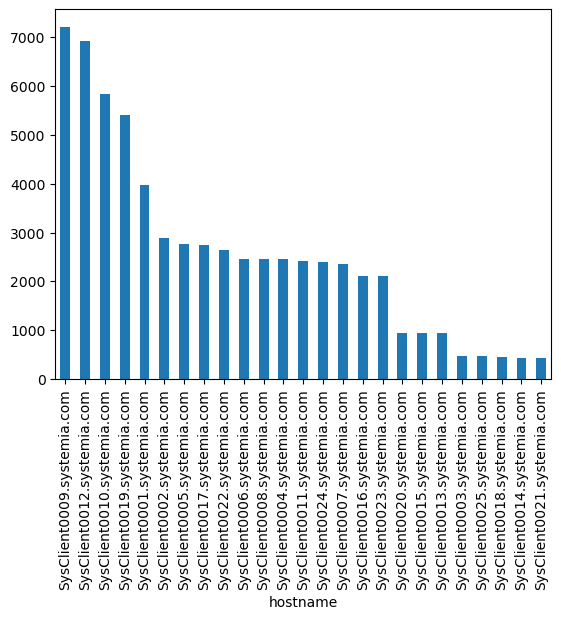

In [68]:
df2.toPandas().groupby('hostname')['dest_ip'].count().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot: xlabel='action'>

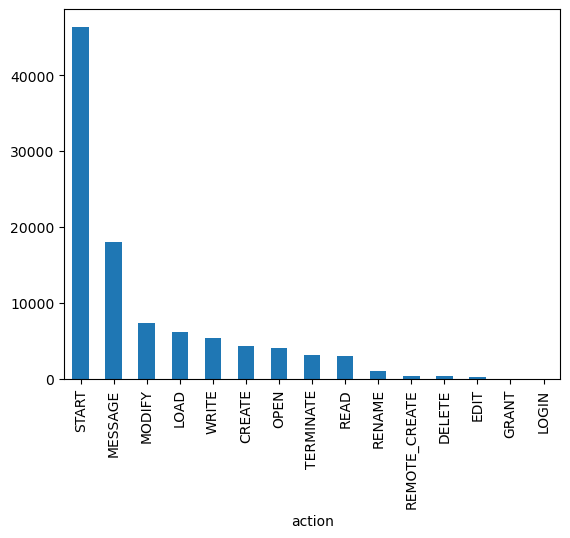

In [72]:
df2.toPandas().groupby('action')['id'].count().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot: xlabel='object'>

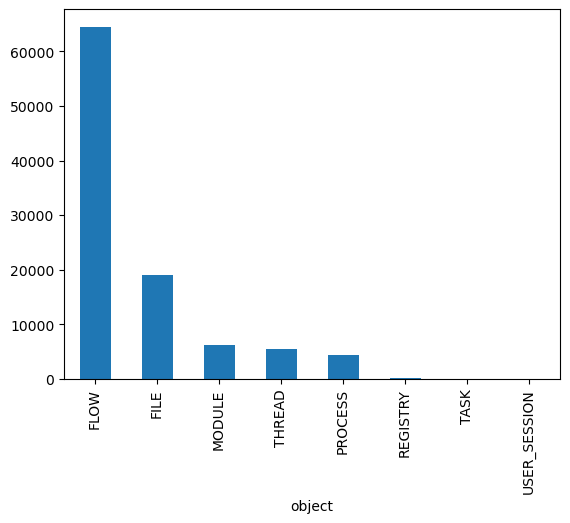

In [73]:
df2.toPandas().groupby('object')['id'].count().sort_values(ascending=False).plot(kind='bar')

In [79]:
loadAndCheckpoint('labels')

--- 5.412447690963745 seconds ---


In [80]:
df_labels = readCheckpoint('labels')

--- 0.25539445877075195 seconds ---


In [88]:
df_labels.count()

292367

In [81]:
df_labels.limit(5).toPandas()

,hostname,id,objectID,actorID,timestamp,object,action
0,SysClient0559.systemia.com,a2d7cb61-31fb-43fb-9d8b-8901374d1d1b,01f1f2a1-8ce9-41e6-89b2-0d1c94224c7d,53efe8c9-3c95-4dfc-aa2f-c75ae4b92a9f,2019-09-23T15:14:48.477-04:00,FLOW,MESSAGE
1,SysClient0559.systemia.com,66bc41c3-4efb-4018-82c8-be54caed81a4,9ba68494-a5b8-48ec-ab9a-a931b20bb846,53efe8c9-3c95-4dfc-aa2f-c75ae4b92a9f,2019-09-23T15:14:59.963-04:00,SHELL,COMMAND
2,SysClient0559.systemia.com,967d5a3d-016f-49da-96f7-4f4ce0e22d32,9ba68494-a5b8-48ec-ab9a-a931b20bb846,53efe8c9-3c95-4dfc-aa2f-c75ae4b92a9f,2019-09-23T15:14:59.961-04:00,SHELL,COMMAND
3,SysClient0559.systemia.com,aa20a2dd-7af6-44de-824c-2841ab5d858f,9ba68494-a5b8-48ec-ab9a-a931b20bb846,53efe8c9-3c95-4dfc-aa2f-c75ae4b92a9f,2019-09-23T15:14:59.981-04:00,SHELL,COMMAND
4,SysClient0559.systemia.com,54917063-84e4-4be5-b899-d51dc635cb34,ef4a070f-cb83-4c0b-a043-dbf982569c69,53efe8c9-3c95-4dfc-aa2f-c75ae4b92a9f,2019-09-23T15:14:59.987-04:00,FLOW,START


<AxesSubplot: xlabel='hostname'>

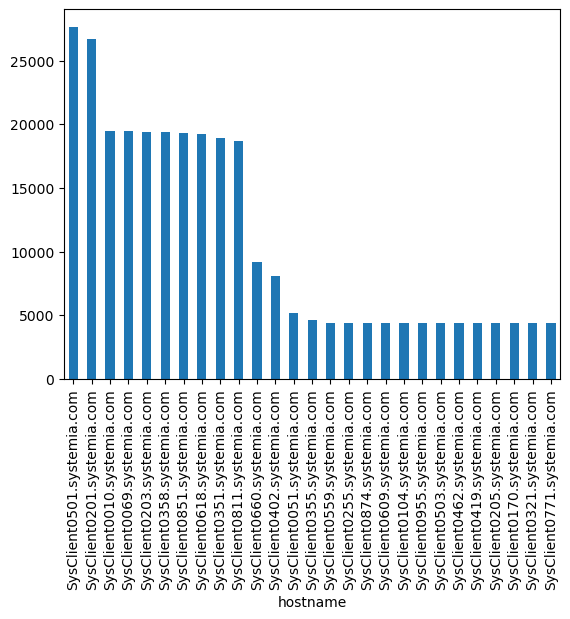

In [84]:
df_labels.toPandas().groupby('hostname')['id'].count().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot: xlabel='action'>

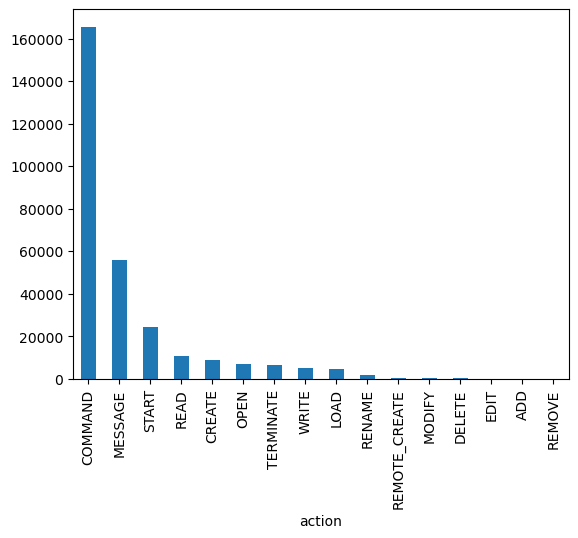

In [85]:
df_labels.toPandas().groupby('action')['id'].count().sort_values(ascending=False).plot(kind='bar')

<AxesSubplot: xlabel='object'>

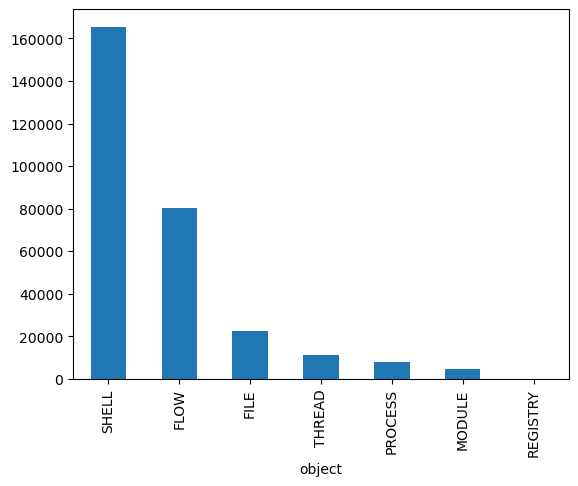

In [86]:
df_labels.toPandas().groupby('object')['id'].count().sort_values(ascending=False).plot(kind='bar')

In [1]:
df_labels.distinct().count()

NameError: name 'df_labels' is not defined